<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков-и-выборок" data-toc-modified-id="Создание-признаков-и-выборок-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков и выборок</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#Аализ-моделей" data-toc-modified-id="Аализ-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Аализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [5]:
pth = '/datasets/taxi.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth,index_col=['datetime'], parse_dates=['datetime'])
else:
    print('Something is wrong')

Ознакомимся с данными до ресемплирования.


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
#Отсортируем и ресемплируем данные по одному часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [10]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выгруженные данные соответствуют описанию задачи, было проведено ресемплирование данных по одному часу, всего данных 4416.

## Анализ

In [11]:
#Проверим данные на наличие пропусков
data.isna().sum()

num_orders    0
dtype: int64

Дубликатов в нашем проэкте быть не может, поэтому принебрежем их обработкой

In [12]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Среднее количество заказов каждый час - 84, медиана - 78, мининальное количество  - 0, максимальное - 462.

In [13]:
data[data['num_orders'] == 0]

,num_orders
datetime,
2018-04-06 06:00:00,0


Нулевое значения заказов за все время было только один раз, возможно это аномалия

Возьмем размером окна скользящего среднего равного часам в сутках.
    


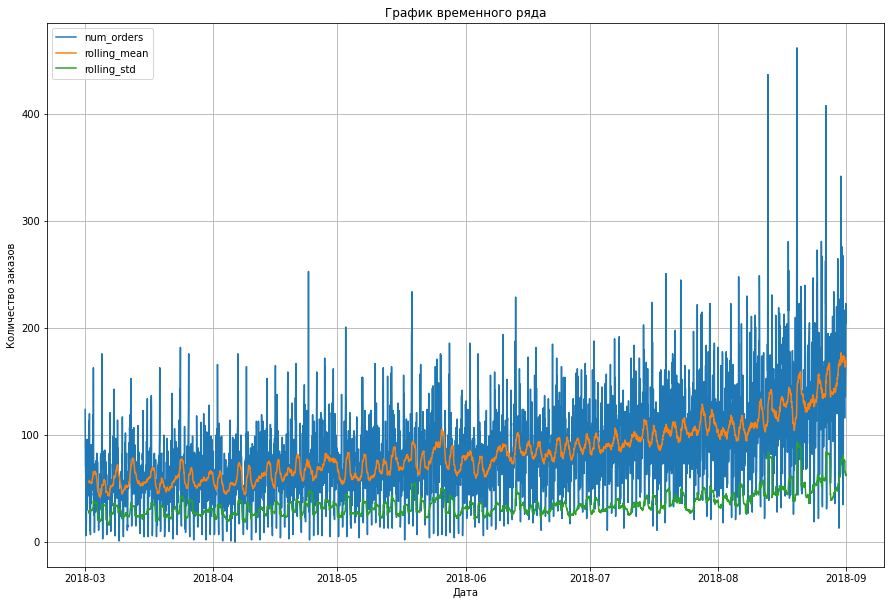

In [14]:
df = data.copy()
df['rolling_mean'] = df['num_orders'].rolling(24).mean()
df['rolling_std'] = df['num_orders'].rolling(24).std()
#Построим график нашего временного ряда

fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x=df.index, y='num_orders', data=df, ax=ax, label='num_orders')
sns.lineplot(x=df.index, y='rolling_mean', data=df, ax=ax, label='rolling_mean')
sns.lineplot(x=df.index, y='rolling_std', data=df, ax=ax, label='rolling_std')
ax.set_title('График временного ряда')
ax.set_ylabel('Количество заказов')
ax.set_xlabel('Дата')
ax.grid(True)

На графике можеи наблюдать нестационарный временной ряд


Возьмем окно скользящего среднего, как количество часов в неделе - 168

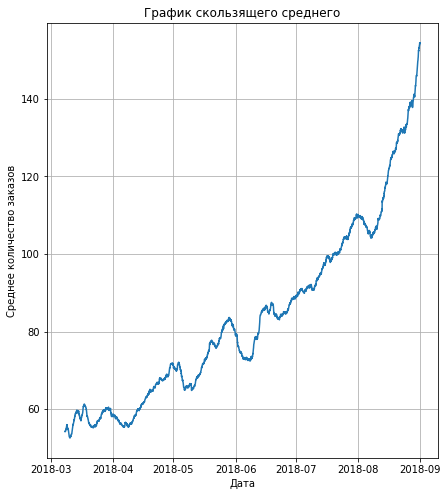

In [15]:
#Построим скользящую среднюю
fig, ax = plt.subplots(figsize=(7,8))
ax = sns.lineplot(x=data.index, y=data['num_orders'].rolling(168).mean(), data=data)
ax.set_title('График скользящего среднего')
ax.set_ylabel('Среднее количество заказов')
ax.set_xlabel('Дата')
ax.grid(True)

Теперь можно заметить явно восходящий тренд 

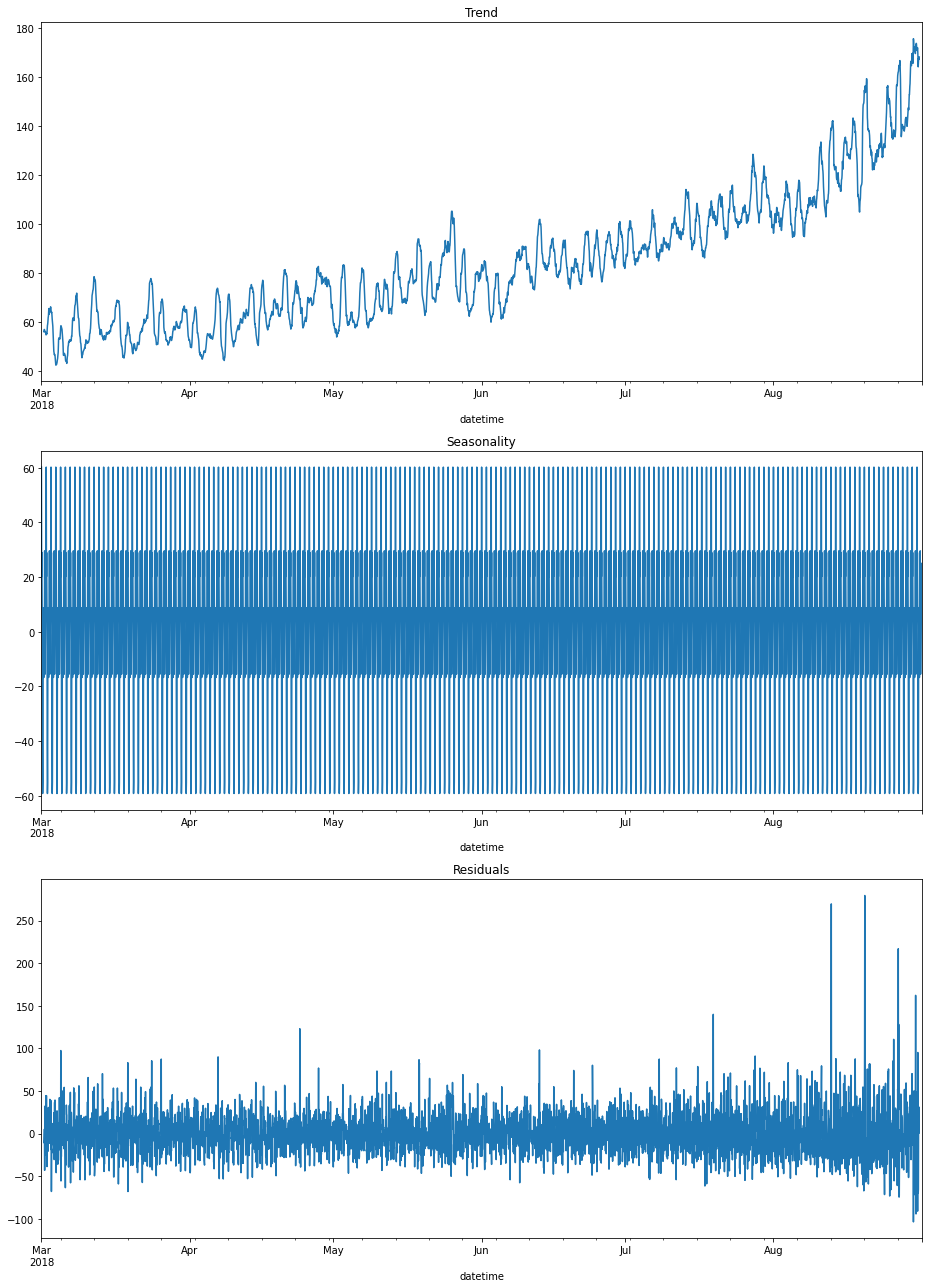

In [16]:
#Проведем анализ временных рядов
decomposed = seasonal_decompose(data)

plt.figure(figsize=(13, 18))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Графики показывают высокую частотность, уменьшим интервал:

Выведем сезонность в большем масштабе

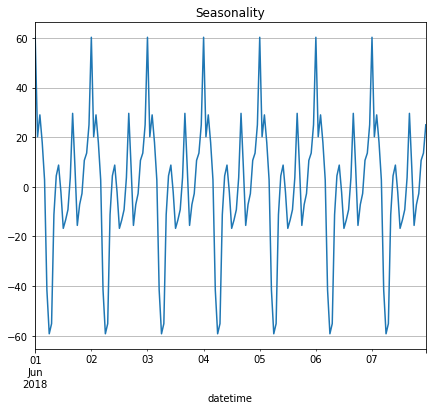

In [17]:
plt.figure(figsize=(7, 6))
decomposed.seasonal['2018-06-01':'2018-06-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)

Теперь можно заметить суточную сезонность, к ночи количество заказов резко уменьшается, в то время как, вечером максимальная нагрузка.

В этом этапе был произведен анализ данных, была выявлена суточная сезонность: 
- пик заказов приходится на вечер, а ночью количество заказов сильно уменьшается

Тренд является восходящим, временной ряд является нестационарным

## Обучение

### Создание признаков и выборок

Напишем функцию для создания признаков

In [18]:
def create_features(data, max_log, rolling_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(1, max_log+1):
        data[f'log_{i}'] = data['num_orders'].shift(i)
        
    data['mean_roll'] = data['num_orders'].shift().rolling(rolling_size).mean()

Исследуем автокорреляцию с помощью PACF и ACF

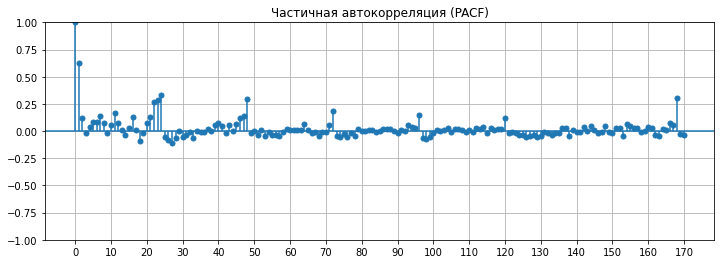

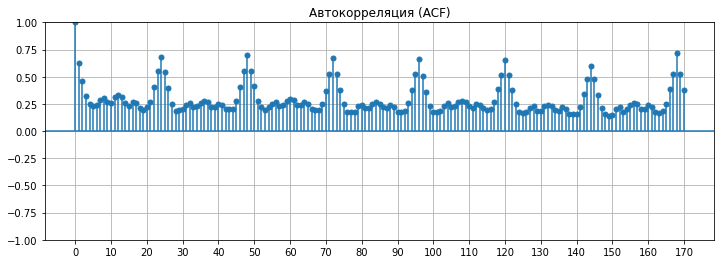

In [19]:
plot_pacf(data, lags=170, alpha=None).set_size_inches(12, 4)
plt.title('Частичная автокорреляция (PACF)')
plt.grid(True)
plt.xticks(np.arange(0, 180, 10))
plt.show()


# Настройка графиков ACF
plot_acf(data, lags=170, alpha=None).set_size_inches(12, 4)
plt.title('Автокорреляция (ACF)')
plt.xticks(np.arange(0, 180, 10))
plt.grid(True)
plt.show()

Скользящее среднее установим равным неделе

In [20]:
create_features(data, 24, 168)

In [21]:
data = data.dropna()

In [22]:
data.head()

,num_orders,hour,dayofweek,log_1,log_2,log_3,log_4,log_5,log_6,log_7,...,log_16,log_17,log_18,log_19,log_20,log_21,log_22,log_23,log_24,mean_roll
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810


Разделим данные на тренировочную, валидационную и тестовую выборки

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('num_orders', axis=1),
    data['num_orders'],
    test_size=TEST_SIZE,
    shuffle=False
)

In [24]:
print(f'Размер тренировочной выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер тренировочной выборки: (3823, 27)
Размер тестовой выборки: (425, 27)


### CatBoostRegressor

In [25]:
params = {
    'iterations': 1000,
    'random_seed': RANDOM_STATE,
    'early_stopping_rounds': 50
}

param_grid = {
    'learning_rate': [0.02, 0.1],
    'depth': [4, 6, 10]
}


model_catboost = CatBoostRegressor(**params)

new_cv = TimeSeriesSplit(n_splits=3).split(X_train)

cb_grid = GridSearchCV(model_catboost, param_grid, scoring='neg_root_mean_squared_error', cv=new_cv)
cb_grid.fit(X_train, y_train, verbose=100)

0:	learn: 29.3440505	total: 48.3ms	remaining: 48.3s
100:	learn: 19.2909148	total: 216ms	remaining: 1.92s
200:	learn: 17.2270867	total: 383ms	remaining: 1.52s
300:	learn: 16.0702196	total: 543ms	remaining: 1.26s
400:	learn: 15.2963395	total: 713ms	remaining: 1.06s
500:	learn: 14.5439205	total: 891ms	remaining: 888ms
600:	learn: 13.7929198	total: 1.05s	remaining: 696ms
700:	learn: 13.1477192	total: 1.2s	remaining: 511ms
800:	learn: 12.5509230	total: 1.35s	remaining: 336ms
900:	learn: 11.9960543	total: 1.49s	remaining: 164ms
999:	learn: 11.4630674	total: 1.64s	remaining: 0us
0:	learn: 32.7239335	total: 2.75ms	remaining: 2.75s
100:	learn: 21.7463125	total: 214ms	remaining: 1.9s
200:	learn: 19.7260463	total: 456ms	remaining: 1.81s
300:	learn: 18.7066111	total: 660ms	remaining: 1.53s
400:	learn: 17.9144932	total: 848ms	remaining: 1.27s
500:	learn: 17.3274105	total: 1.05s	remaining: 1.04s
600:	learn: 16.7305098	total: 1.23s	remaining: 814ms
700:	learn: 16.1828708	total: 1.42s	remaining: 607ms

GridSearchCV(cv=<generator object TimeSeriesSplit._split at 0x7fadc1f0bf90>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fadcb840310>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.02, 0.1]},
             scoring='neg_root_mean_squared_error')

In [26]:
print(f'Лучшие гиперпараметры: {cb_grid.best_params_}')
print(f'Лучшая метрика: {(cb_grid.best_score_ * (-1)):.2f}')

Лучшие гиперпараметры: {'depth': 6, 'learning_rate': 0.02}
Лучшая метрика: 26.22


### Ridge

Отмасштабируем данные и закодируем hour и dayofweek при помощи OHE

In [30]:
num_cols = data.columns[3:27 + 1].tolist()
ohe_cols = ['hour', 'dayofweek']

data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ohe_cols),
     ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

pipe_r = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', Ridge())
])

new_cv = TimeSeriesSplit(n_splits=3).split(X_train)

hyperparams = [{'model__alpha': [0.1, 1.0, 10.0],
                'model__fit_intercept': [True, False],
                'model__solver': ['auto', 'svd', 'cholesky']}]

r_model = GridSearchCV(
    estimator = pipe_r,
    param_grid=hyperparams,
    scoring='neg_root_mean_squared_error',
    cv=new_cv
)

r_model.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit._split at 0x7fadcbea6cf0>,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['hour',
                                                                          'dayofweek']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['log_1',
                                                                          'log_2',
                                                                          'log_3',
                                                                          'log_4',
                                                                          'log_5',
                                                                          'log_6',
                                                                          'log_7',
                                                                          'log_8',
                                                                          'log_9',
                                                                          'log_10',
                                                                          'log_11',
                                                                          'log_12',
                                                                          'log_13',
                                                                          'log_14',
                                                                          'log_15',
                                                                          'log_16',
                                                                          'log_17',
                                                                          'log_18',
                                                                          'log_19',
                                                                          'log_20',
                                                                          'log_21',
                                                                          'log_22',
                                                                          'log_23',
                                                                          'log_24',
                                                                          'mean_roll'])])),
                                       ('model', Ridge())]),
             param_grid=[{'model__alpha': [0.1, 1.0, 10.0],
                          'model__fit_intercept': [True, False],
                          'model__solver': ['auto', 'svd', 'cholesky']}],
             scoring='neg_root_mean_squared_error')

In [31]:
print(f'Лучшие гиперпараметры: {r_model.best_params_}')
print(f'Лучшая метрика: {(r_model.best_score_ * (-1)):.2f}')

Лучшие гиперпараметры: {'model__alpha': 0.1, 'model__fit_intercept': True, 'model__solver': 'svd'}
Лучшая метрика: 25.92


### Аализ моделей

Лучшей моделью стала Ridge с метрикой RMSE = 25.92 и гиперпараметрами model__alpha: 0.1, model__fit_intercept: True, model__solver: 'svd'. У CatBoostRegressor RMSE = 26.22, однако время затраченное на обучение и подбор гиперпараметров намного больше чем у простой линейной модели Ridge, поэтому использовать будем Ridge.

## Тестирование

In [33]:
r_model_pred = r_model.predict(X_test)

rmse_r = mean_squared_error(y_test, r_model_pred, squared=False)
print(f'RMSE модели Ridge на тестовой выборке: {rmse_r:.2f}')

RMSE модели Ridge на тестовой выборке: 40.85


    Линейная модель опказалась переобучена, но метрика RMSE в пределах допустимой.
    RMSE на тестовой выборке также  у Ridge 40.85

## Вывод

В ходе проектной работы была разработана модель, которая позволит спрогнозировать количество заказов такси на следующий час.

Первым шагом стала подготовка данных: данные были выгружены в таблицу размером 4416 и изучены, было проведено ресемплирование данных по одному часу.

Во втором шаге проводился анализ данных: были проведено исследование наличия пропусков и дубликатов, были построены графики распределения количества заказов и общий график временного ряда, был проведен анализ временных рядов: построены графики тренда, сезонности и остатков, было выяснено, что тренд восходящий и существует определенная суточная сезонность: пик заказов приходится на вечер, а ночью количество заказов сильно уменьшается.

В третем шаге проводилось обучение моделей: для начала были созданы функции для создания признаков, такие как час дня и день недели, скользящее среднее и информация о количестве заказов в течении предыдущих 24 часов, далее данные были разбиты на тренировочную и тестовую выборки и обучены модели CatBoostRegressor и Ridge. Были подобраны лучшие гиперпараметры, оценка качества проводилась с помощью метрики RMSE.

В четвертом шаге проходило тестирование моделей:  RMSE модели Ridge 40.85.